# 2022 NBA Champion Prediction

In [1]:
import time
from pathlib import Path
from typing import Any, TypeAlias

import numpy as np
import pandas as pd
import seaborn as sns
import tomli
from matplotlib import pyplot as plt
from pandas import Series
from rich.pretty import pprint
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    LabelEncoder,
    StandardScaler,
)
from sqlalchemy import MetaData, and_, create_engine, select
from sqlalchemy.orm import DeclarativeBase, Session, aliased
from sqlalchemy.orm.decl_api import DeclarativeAttributeIntercept

### Notebook Constants

In [2]:
# Directories.
project_dir = Path.cwd().parent
secrets_path = project_dir / "secrets.toml"
images_dir = project_dir / "machine_learning" / "images"

# Season to predict the champion for.
season_current = 2022
# Season values for the machine learning (ml) model.
season_ml_start = 2016
season_ml_end = season_current - 1

image_dpi = 240.0

## Retrieve Stats
### Setup Database Connection and Mapped Classes
#### Construct Database URI

In [3]:
with open(secrets_path, "rb") as f:
    secrets = tomli.load(f)

# Host, port and database values.
host = secrets["DATABASE"]["HOST"]
port = secrets["DATABASE"]["PORT"]
db = secrets["DATABASE"]["DB"]

# User credentials.
user = secrets["USER"]["USERNAME"]
pwd = secrets["USER"]["PASSWORD"]

# Build database URI.
db_uri = f"postgresql://{user}:{pwd}@{host}:{port}/{db}"

#### Create SQLAlchemy Engine and Reflect The Database

In [4]:
# Create the connection to the database.
engine = create_engine(db_uri)

# Create the metadata object that will hold database table information.
metadata_obj = MetaData()
# Collect table information via database reflection.
metadata_obj.reflect(bind=engine)

#### ORM Mapped Classes

In [5]:
# Create the mapped classes via the metadata information. A subclass of the SQLAlchemy `DeclarativeBase` class is
# required. This subclass (called `Base`) is then subclassed by each class that will represent a table in the
# database. See SQLAlchemy documentation for more info.


class Base(DeclarativeBase):
    pass


class Teams(Base):
    __table__ = metadata_obj.tables["teams"]


class Seasons(Base):
    __table__ = metadata_obj.tables["seasons"]


class SeasonRecords(Base):
    __table__ = metadata_obj.tables["season_records"]


class PlayoffRecords(Base):
    __table__ = metadata_obj.tables["playoff_records"]


class TeamsTraditional(Base):
    __table__ = metadata_obj.tables["teams_traditional"]


class TeamsAdvanced(Base):
    __table__ = metadata_obj.tables["teams_advanced"]


class TeamsMisc(Base):
    __table__ = metadata_obj.tables["teams_misc"]


class TeamsClutch(Base):
    __table__ = metadata_obj.tables["teams_clutch"]


class PlayoffsTraditional(Base):
    __table__ = metadata_obj.tables["playoffs_traditional"]


class PlayoffsAdvanced(Base):
    __table__ = metadata_obj.tables["playoffs_advanced"]


class PlayoffsMisc(Base):
    __table__ = metadata_obj.tables["playoffs_misc"]


class PlayoffsClutch(Base):
    __table__ = metadata_obj.tables["playoffs_clutch"]


class PlayoffTeamsLong(Base):
    __table__ = metadata_obj.tables["playoff_teams_long"]


class Champions(Base):
    __table__ = metadata_obj.tables["champions"]

#### Helper Function: Get ORM Mapped Class 

In [6]:
MappedClass: TypeAlias = DeclarativeAttributeIntercept


def get_mapped_class(table_name: str, global_vars: dict[str, Any]) -> MappedClass:
    """Get the sqlalchemy ORM class for the given `table_name` from `global_vars`."""
    name_list = table_name.split("_")
    name_list = [name.title() for name in name_list]
    class_name = "".join(name_list)
    return global_vars[class_name]

#### Dict of Mapped Classes

In [7]:
global_vars = globals()
mapped_classes = {}
for name in metadata_obj.tables:
    if name != "playoff_teams":
        mapped_classes[name] = get_mapped_class(name, global_vars)

pprint(mapped_classes, indent_guides=False, expand_all=True)

{
    'seasons': <class '__main__.Seasons'>,
    'season_records': <class '__main__.SeasonRecords'>,
    'teams': <class '__main__.Teams'>,
    'playoff_records': <class '__main__.PlayoffRecords'>,
    'teams_traditional': <class '__main__.TeamsTraditional'>,
    'teams_advanced': <class '__main__.TeamsAdvanced'>,
    'teams_misc': <class '__main__.TeamsMisc'>,
    'teams_clutch': <class '__main__.TeamsClutch'>,
    'playoffs_traditional': <class '__main__.PlayoffsTraditional'>,
    'playoffs_advanced': <class '__main__.PlayoffsAdvanced'>,
    'playoffs_misc': <class '__main__.PlayoffsMisc'>,
    'playoffs_clutch': <class '__main__.PlayoffsClutch'>,
    'playoff_teams_long': <class '__main__.PlayoffTeamsLong'>,
    'champions': <class '__main__.Champions'>
}

### Retrieve and Verify
#### Build Query and Retrieve Tables Using `sqlalchemy`

In [8]:
with Session(engine) as session:
    # Create aliases for each table to simplify the query below.
    tt = aliased(mapped_classes["teams_traditional"])
    ta = aliased(mapped_classes["teams_advanced"])
    tm = aliased(mapped_classes["teams_misc"])
    sr = aliased(mapped_classes["season_records"])

    # Create a SQL query statement using the SQLAlchemy `select` and its methods such as `join` and `where`
    # (the query is not executed at this point).
    query = (
        select(tt, ta, tm, sr.CHAMPION)
        .join(ta, and_(tt.SEASON == ta.SEASON, tt.TEAM == ta.TEAM))
        .join(tm, and_(tt.SEASON == tm.SEASON, tt.TEAM == tm.TEAM))
        .join(sr, and_(tt.SEASON == sr.SEASON, tt.TEAM == sr.TEAM))
        .where(tt.SEASON.between(season_ml_start, season_current), sr.PLAYOFFS == True)
    )

    # Use `pd.read_sql` to execute the query on the database and return a DataFrame.
    start_time = time.perf_counter()
    stats = pd.read_sql(sql=query, con=engine)
    print(f"\ndatabase query execution time: {time.perf_counter() - start_time:.2f}s")

    # Drop redundant columns.
    stats = stats.drop(columns=["SEASON_1", "TEAM_1", "SEASON_2", "TEAM_2"])

    # Split the `stats` table into two tables, one containing the current season and one containing the ml model seasons.
    current_stats = stats[stats["SEASON"] == season_current]
    # The current season does not have a champion so the column is dropped.
    current_stats = current_stats.drop(columns="CHAMPION")
    model_stats = stats[stats["SEASON"].between(season_ml_start, season_ml_end)]

    current_stats = current_stats.reset_index(drop=True)
    model_stats = model_stats.reset_index(drop=True)


database query execution time: 0.58s


#### Check Results

In [9]:
current_stats.columns

Index(['SEASON', 'TEAM', 'WIN%', 'PTS', 'FGM', 'FGA', 'FG%', '3PM', '3PA',
       '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL',
       'BLK', 'BLKA', 'PF', 'PFD', '+/-', 'OFFRTG', 'DEFRTG', 'NETRTG', 'AST%',
       'AST/TO', 'AST_RATIO', 'OREB%', 'DREB%', 'REB%', 'TOV%', 'EFG%', 'TS%',
       'PACE', 'PIE', 'POSS', 'PTS_OFF_TO', '2ND_PTS', 'FBPS', 'PITP',
       'OPP_PTS_OFF_TO', 'OPP_2ND_PTS', 'OPP_FBPS', 'OPP_PITP'],
      dtype='object')

In [10]:
current_stats["SEASON"].value_counts()

SEASON
2022    16
Name: count, dtype: int64

In [11]:
current_stats.head()

,SEASON,TEAM,WIN%,PTS,FGM,FGA,FG%,3PM,3PA,3P%,...,PIE,POSS,PTS_OFF_TO,2ND_PTS,FBPS,PITP,OPP_PTS_OFF_TO,OPP_2ND_PTS,OPP_FBPS,OPP_PITP
0,2022,Phoenix Suns,0.780,114.8,43.7,90.1,48.5,11.6,31.9,36.4,...,54.8,8242,18.1,12.1,12.5,49.8,14.8,13.6,11.3,45.2
1,2022,Memphis Grizzlies,0.683,115.6,43.5,94.4,46.1,11.5,32.7,35.3,...,53.0,8295,18.3,18.7,17.7,57.6,14.5,13.0,13.2,47.4
2,2022,Golden State Warriors,0.646,111.0,40.5,86.4,46.9,14.3,39.4,36.4,...,53.6,8121,17.6,12.6,13.8,44.7,16.9,12.7,12.3,43.9
3,2022,Miami Heat,0.646,110.0,39.6,84.8,46.7,13.6,35.8,37.9,...,52.9,7987,17.2,12.7,10.9,43.0,16.7,12.6,12.2,41.3
4,2022,Dallas Mavericks,0.634,108.0,39.3,85.1,46.1,13.1,37.4,35.0,...,51.1,7871,14.9,11.0,10.0,42.9,14.4,13.1,12.0,47.1


In [12]:
model_stats["SEASON"].value_counts()

SEASON
2021    16
2020    16
2019    16
2018    16
2017    16
2016    16
Name: count, dtype: int64

In [13]:
model_stats

,SEASON,TEAM,WIN%,PTS,FGM,FGA,FG%,3PM,3PA,3P%,...,POSS,PTS_OFF_TO,2ND_PTS,FBPS,PITP,OPP_PTS_OFF_TO,OPP_2ND_PTS,OPP_FBPS,OPP_PITP,CHAMPION
0,2021,Utah Jazz,0.722,116.4,41.3,88.1,46.8,16.7,43.0,38.9,...,7193,14.1,13.6,11.9,44.2,17.0,12.4,12.1,49.1,False
1,2021,Phoenix Suns,0.708,115.3,43.3,88.3,49.0,13.1,34.6,37.8,...,7137,16.1,12.9,13.1,45.3,14.8,12.4,12.0,47.4,False
2,2021,Philadelphia 76ers,0.681,113.6,41.4,86.9,47.6,11.3,30.1,37.4,...,7272,18.1,13.9,15.2,47.3,17.2,11.6,14.3,46.0,False
3,2021,Brooklyn Nets,0.667,118.6,43.1,87.3,49.4,14.2,36.1,39.2,...,7280,15.8,12.3,14.3,49.2,16.1,15.3,12.1,47.8,False
4,2021,Denver Nuggets,0.653,115.1,43.3,89.2,48.5,12.9,34.2,37.7,...,7123,18.0,13.8,12.4,49.7,15.6,11.3,13.4,45.2,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2016,Detroit Pistons,0.537,102.0,37.9,86.4,43.9,9.0,26.2,34.5,...,7942,15.4,14.9,11.1,43.5,14.6,10.7,10.4,44.4,False
92,2016,Portland Trail Blazers,0.537,105.1,38.6,85.9,45.0,10.5,28.5,37.0,...,8012,14.8,14.1,10.7,39.1,16.3,12.4,11.1,40.9,False
93,2016,Dallas Mavericks,0.512,102.3,37.4,84.1,44.4,9.8,28.6,34.4,...,7950,16.0,10.6,11.2,38.0,14.8,13.4,16.0,40.9,False
94,2016,Memphis Grizzlies,0.512,99.1,36.8,83.6,44.0,6.1,18.5,33.1,...,7763,17.9,12.9,12.6,44.0,15.1,11.8,14.6,38.5,False


<br>
<hr>
<br>

## Feature Selection
### Definition
- feature - a stat type (i.e. a numeric column from the `model_stats` DataFrame)
### Outline
- Analyze the correlations between features as well as the cumulative explained variance using all features.
- Use the results to select the final features for the logistic regression model.
#### Analysis: All Features
1. Correlation coefficient matrix and heatmap.
1. Investigate maximum and 80th percentile correlations - identify the most independent features.
1. Use principal component analysis (PCA) to build a cumulative explained variance (CEV) plot.
1. Use the CEV plot to identify the number of features to aim for.
1. Select the features to be used in the model.
#### Analysis: Selected Features
1. Correlation coefficient matrix and heatmap.
1. CEV plot.

### Constants

In [14]:
percentile = 0.80
# Threshold for max correlation coefficient graph.
max_corr_threshold = 0.80
# Threshold for percentile correlation coefficient graph.
percentile_corr_threshold = 0.35

### Feature Lists
#### All Features

In [15]:
all_features = [
    "WIN%",
    "PTS",
    "FGM",
    "FGA",
    "FG%",
    "3PM",
    "3PA",
    "3P%",
    "FTM",
    "FTA",
    "FT%",
    "OREB",
    "DREB",
    "REB",
    "AST",
    "TOV",
    "STL",
    "BLK",
    "BLKA",
    "PF",
    "PFD",
    "+/-",
    "OFFRTG",
    "DEFRTG",
    "NETRTG",
    "AST%",
    "AST/TO",
    "AST_RATIO",
    "OREB%",
    "DREB%",
    "REB%",
    "TOV%",
    "EFG%",
    "TS%",
    "PACE",
    "PIE",
    "POSS",
    "PTS_OFF_TO",
    "2ND_PTS",
    "FBPS",
    "PITP",
    "OPP_PTS_OFF_TO",
    "OPP_2ND_PTS",
    "OPP_FBPS",
    "OPP_PITP",
]

#### Selected Features (ML Model Features)

In [16]:
# Uncomment/comment to select/deselect features for the ml model.
selected_features = [
    # 'WIN%',
    # 'PTS',
    # 'FGM',
    # 'FGA',
    # 'FG%',
    # '3PM',
    # '3PA',
    "3P%",
    # 'FTM',
    # 'FTA',
    # 'FT%',
    # 'OREB',
    "DREB",
    # 'REB',
    # 'AST',
    # 'TOV',
    "STL",
    "BLK",
    # 'BLKA',
    # 'PF',
    # 'PFD',
    # '+/-',
    "OFFRTG",
    "DEFRTG",
    # 'NETRTG',
    # 'AST%',
    "AST/TO",
    # 'AST_RATIO',
    # 'OREB%',
    # 'DREB%',
    # 'REB%',
    # 'TOV%',
    # 'EFG%',
    # 'TS%',
    # 'PACE',
    # 'PIE',
    # 'POSS',
    # 'PTS_OFF_TO',
    # '2ND_PTS',
    # 'FBPS',
    # 'PITP',
    # 'OPP_PTS_OFF_TO',
    # 'OPP_2ND_PTS',
    # 'OPP_FBPS',
    # 'OPP_PITP'
]
print(f"Number of selected features: {len(selected_features)}")

Number of selected features: 7


### Analysis: All Features
#### Correlation Coefficient Matrix

In [17]:
# Create a correlation matrix of all features.
corr_all = model_stats[all_features].corr()

#### Heatmap

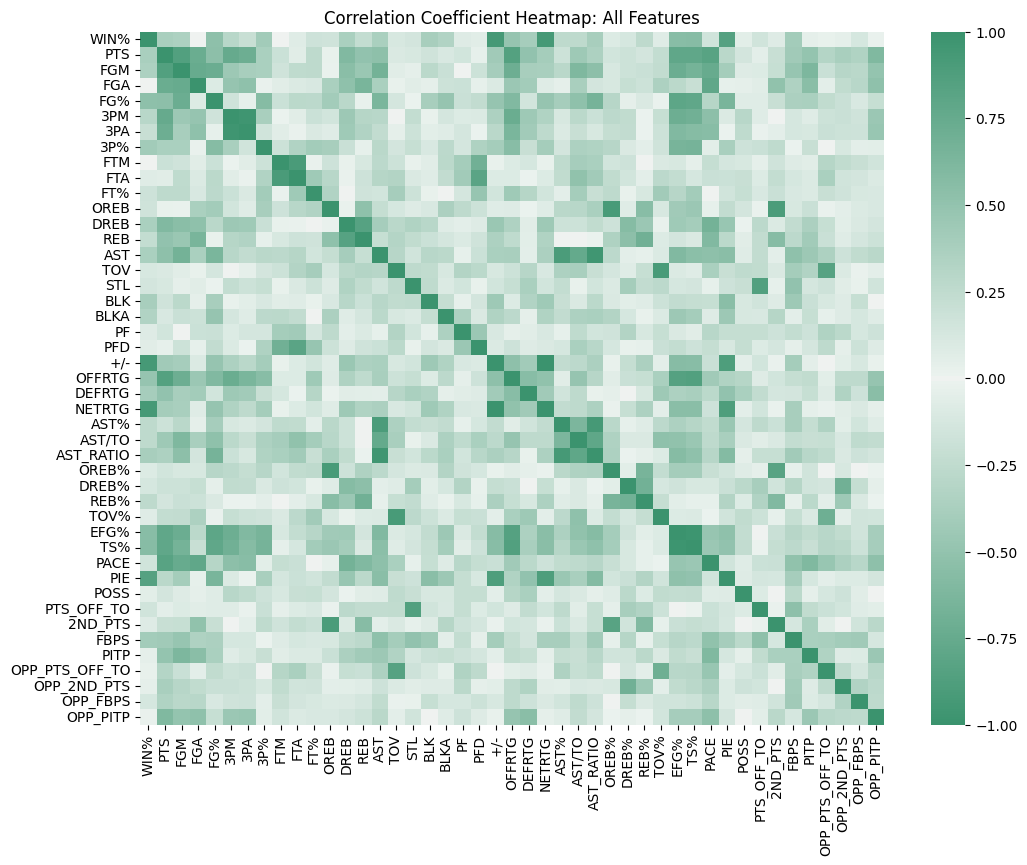

In [18]:
# Plot a heatmap of the correlations.
fig, ax = plt.subplots(figsize=(12, 9))
cmap = sns.diverging_palette(150, 150, s=80, l=55, as_cmap=True)
sns.heatmap(corr_all, cmap=cmap, vmin=-1, vmax=1)
ax.set_title("Correlation Coefficient Heatmap: All Features")

# Save image to file.
fig.savefig(
    fname=images_dir / "correlation_heatmap_all_features.png",
    dpi=image_dpi,
    bbox_inches="tight",
)

plt.show()

#### Maximum and 80th Percentile Correlation Calculations

In [19]:
def get_percentile_corr(corr_col: Series, percentile: float = 1.0) -> float:
    """Returns the percentile value for a given Series `corr_col`."""
    # The value at index 0 is removed since this is just the correlation of the stat with itself.
    corr_col = corr_col.abs().sort_values(ascending=False)[1:]
    return corr_col.quantile(q=percentile)


# Apply `get_percentile_corr` function to each column in `corr`. To find max correlation values, use `get_percentile_corr`
# with the default value for the `percentile` parameter.
max_corrs = corr_all.agg(func=get_percentile_corr)
percentile_corrs = corr_all.agg(func=get_percentile_corr, percentile=percentile)

#### Filter Max Correlations Using Threshold

In [20]:
# Max correlation data.
max_corrs = max_corrs[max_corrs < max_corr_threshold].sort_values(ascending=False)

print(
    f"Number of stats with max r-value < {max_corr_threshold}: {len(max_corrs)} out of {len(all_features)}\n"
)
print(f"Stats with max r-value < {max_corr_threshold}: {list(max_corrs.index)}")

Number of stats with max r-value < 0.8: 16 out of 45

Stats with max r-value < 0.8: ['AST/TO', 'FGA', 'REB%', 'DREB%', 'OPP_2ND_PTS', '3P%', 'PITP', 'OPP_PITP', 'DEFRTG', 'BLK', 'FBPS', 'BLKA', 'FT%', 'PF', 'OPP_FBPS', 'POSS']


#### Max Correlations Plot

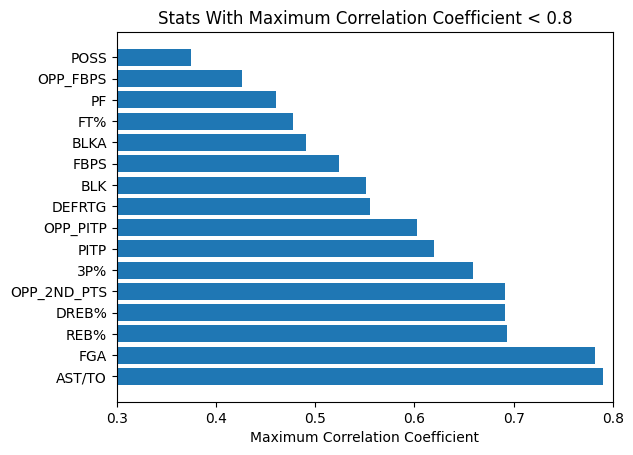

In [21]:
# Max correlation plot.
fig, ax = plt.subplots()
ax.barh(max_corrs.index, max_corrs)
ax.set_title(f"Stats With Maximum Correlation Coefficient < {max_corr_threshold}")
ax.set_xlabel("Maximum Correlation Coefficient")
ax.set_xlim(0.3, 0.8)

# Save image to file.
fig.savefig(
    fname=images_dir / "max_correlation_coefficients.png",
    dpi=image_dpi,
    bbox_inches="tight",
)

plt.show()

#### Filter Percentile Correlations Using Threshold

In [22]:
# Percentile correlation Data.
percentile_corrs = percentile_corrs[
    percentile_corrs < percentile_corr_threshold
].sort_values(ascending=False)

print(
    f"Number of stats with {int(round(100*percentile))}th percentile r-value < {percentile_corr_threshold}: {len(percentile_corrs)} out of {len(all_features)}\n"
)
print(
    f"Stats with {int(round(100*percentile))}th percentile r-value < {percentile_corr_threshold}: {list(percentile_corrs.index)}\n"
)

Number of stats with 80th percentile r-value < 0.35: 20 out of 45

Stats with 80th percentile r-value < 0.35: ['REB%', 'BLKA', 'TOV', 'OPP_PTS_OFF_TO', 'AST%', 'FT%', 'FTA', 'OREB%', 'BLK', 'OPP_2ND_PTS', 'TOV%', 'PF', 'DREB%', 'OPP_FBPS', 'PFD', 'FTM', 'STL', '2ND_PTS', 'PTS_OFF_TO', 'POSS']



#### Percentile Correlations Plot

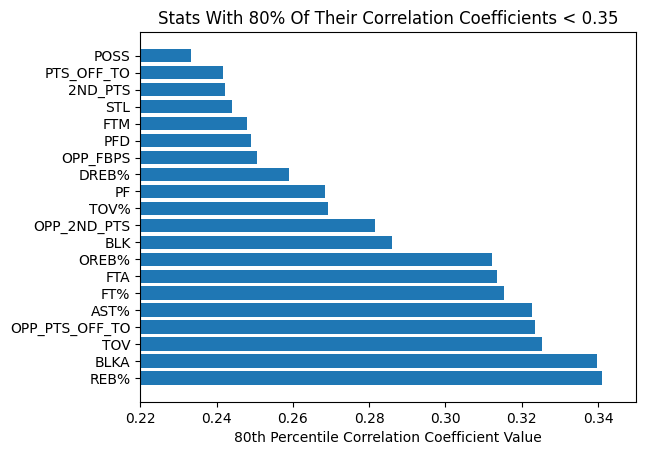

In [23]:
# Percentile correlation plot.
fig, ax = plt.subplots()
ax.barh(percentile_corrs.index, percentile_corrs)
ax.set_title(
    f"Stats With {int(round(100*percentile))}% Of Their Correlation Coefficients < {percentile_corr_threshold}"
)
ax.set_xlabel(
    f"{int(round(100*percentile))}th Percentile Correlation Coefficient Value"
)
ax.set_xlim(0.22, 0.35)

# Save image to file.
fig.savefig(
    fname=images_dir / "percentile_correlation_coefficients.png",
    dpi=image_dpi,
    bbox_inches="tight",
)

plt.show()

#### Principal Component Analysis (PCA) and Cumulative Explained Variance (CEV)

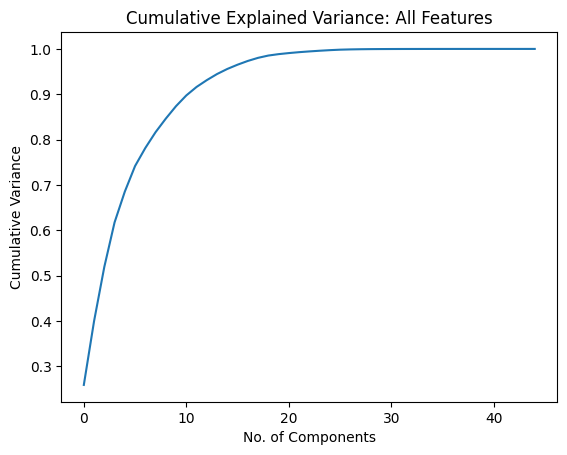

In [24]:
# Create an instance of the `StandardScaler` class.
scaler = StandardScaler()
# Scale the stats to remove the mean and scale to unit variance prior to PCA.
# The output, `model_stats_all_scaled`, is a numpy ndarray.
model_stats_all_scaled = scaler.fit_transform(model_stats[all_features])

# Compute PCA using the scaled all feature stats ndarray.
pca_all = PCA(svd_solver="full").fit(model_stats_all_scaled)

# Cumulative explained variance plot.
fig, ax = plt.subplots()
ax.plot(np.cumsum(pca_all.explained_variance_ratio_))
ax.set_title("Cumulative Explained Variance: All Features")
ax.set_xlabel("No. of Components")
ax.set_ylabel("Cumulative Variance")

# Save image to file.
fig.savefig(
    fname=images_dir / "cumulative_explained_variance_all_features.png",
    dpi=image_dpi,
    bbox_inches="tight",
)

plt.show()

### Analysis: Selected Features
#### Correlation Coefficient Matrix

In [25]:
# Create a correlation matrix of selected features.
corr_selected = model_stats[selected_features].corr()

#### Heatmap

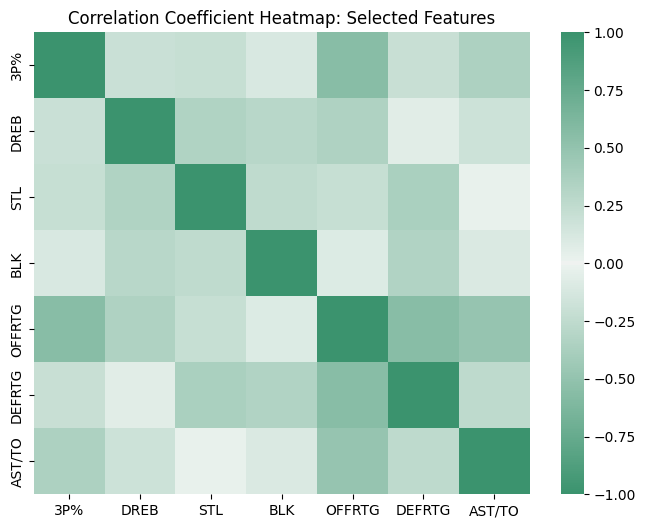

In [26]:
# Plot a heatmap of the correlations
fig, ax = plt.subplots(figsize=(8, 6))
cmap = sns.diverging_palette(150, 150, s=80, l=55, as_cmap=True)
sns.heatmap(corr_selected, cmap=cmap, vmin=-1, vmax=1)
ax.set_title("Correlation Coefficient Heatmap: Selected Features")

# Save image to file.
fig.savefig(
    fname=images_dir / "correlation_heatmap_selected_features.png",
    dpi=image_dpi,
    bbox_inches="tight",
)

plt.show()

#### Principal Component Analysis (PCA) and Cumulative Explained Variance (CEV)

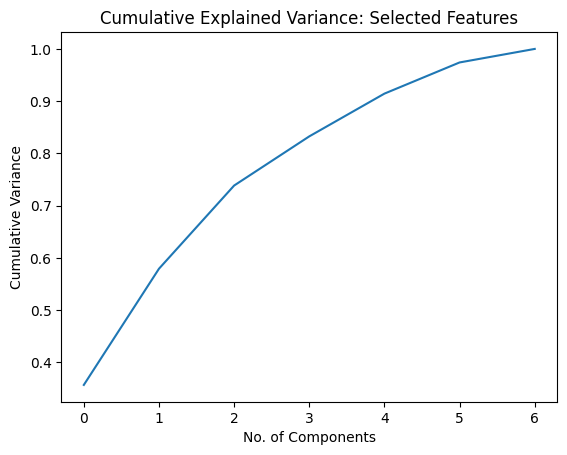

In [27]:
# Scale the selected features prior to PCA. The output, `model_stats_selected_scaled`,
# is a numpy ndarray.
model_stats_selected_scaled = scaler.fit_transform(model_stats[selected_features])

# Compute PCA using the scaled selected feature stats ndarray.
pca_selected = PCA(svd_solver="full").fit(model_stats_selected_scaled)

# Cumulative explained variance plot.
fig, ax = plt.subplots()
ax.plot(np.cumsum(pca_selected.explained_variance_ratio_))
ax.set_title("Cumulative Explained Variance: Selected Features")
ax.set_xlabel("No. of Components")
ax.set_ylabel("Cumulative Variance")

# Save image to file.
fig.savefig(
    fname=images_dir / "cumulative_explained_variance_selected_features.png",
    dpi=image_dpi,
    bbox_inches="tight",
)

plt.show()

<br>
<hr>
<br>

## Machine Learning
### Outline
1. Assign the supervised learning labels using the `"CHAMPION"` column of `model_stats`
1. Create a model with LogisticRegression().
1. Train the model with model.fit().
1. Make predictions with model.predict().
1. Validate the model with accuracy_score().

### Preprocessing
#### One-Hot-Encode Labels

In [28]:
# Assign the labels using the `CHAMPIONS` column.
le = LabelEncoder()
labels = le.fit_transform(model_stats["CHAMPION"])
labels

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

#### Model Input Variables and Test Train Split

In [29]:
# Scale the current stats to match the scaled `model_stats` DataFrame.
current_stats_selected_scaled = scaler.fit_transform(current_stats[selected_features])

# `X` is the model data, `y` is the labels associated with the model data and
# `target` is the current data to be predicted once the model is trained.
X = model_stats_selected_scaled
y = labels
target = current_stats_selected_scaled

# Split the dataset into training and testing sets.
# Stratifying the data is important since we have 25 champions and 375 non-champions (a strong
# imbalance across the two groups).
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=1, stratify=y
)

### Train the Model

In [30]:
# Create a logistic regression model with the specified arguments.
classifier = LogisticRegression(solver="liblinear", max_iter=2000, random_state=1)

# Train the model with the training data
classifier.fit(X_train, y_train)

LogisticRegression(max_iter=2000, random_state=1, solver='liblinear')

### Test and Validate the Model
#### Predict Using Test Data and Check Accuracy

In [31]:
# Create predictions for y-values
y_prediction = classifier.predict(X_test)

# Accuracy score
print(f"Accuracy: {round(accuracy_score(y_test, y_prediction), 2)}")

# Keep in mind that the test train split was stratified when viewing the
# `results` DataFrame.
results = pd.DataFrame({"Prediction": y_prediction, "Actual": y_test})
results

Accuracy: 0.92


,Prediction,Actual
0,0,0
1,0,0
2,0,0
3,0,1
4,0,0
5,0,0
6,0,0
7,1,0
8,0,0
9,1,1


#### Confusion Matrix

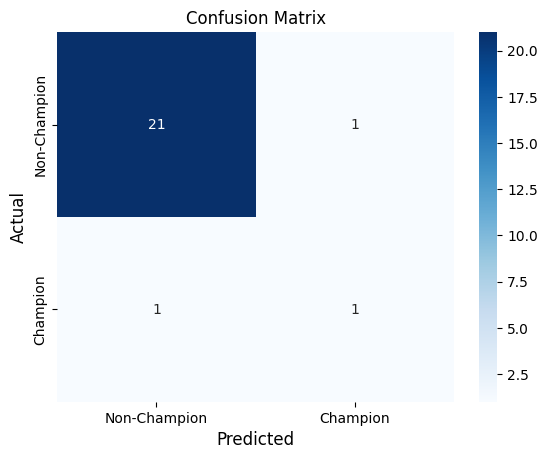

In [32]:
# Generate the confusion matrix.
confusion = confusion_matrix(y_test, y_prediction)

# Confusion matrix plot.
fig, ax = plt.subplots()
sns.heatmap(
    confusion,
    xticklabels=["Non-Champion", "Champion"],
    yticklabels=["Non-Champion", "Champion"],
    annot=True,
    cmap="Blues",
)
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted", fontsize=12)
ax.set_ylabel("Actual", fontsize=12)

# Save image to file.
fig.savefig(
    fname=images_dir / "confusion_matrix.png",
    dpi=image_dpi,
    bbox_inches="tight",
)

plt.show()

### Predict the Champion
#### Predicted Labels

In [33]:
# Predict and print out the champion team.
current_prediction = classifier.predict(current_stats_selected_scaled)
champions = current_stats.iloc[current_prediction.nonzero()]["TEAM"]
champion_str = ", ".join(list(champions.array))
print(f"Predicted Champion: {champion_str}")

Predicted Champion: Memphis Grizzlies


#### Probability Estimates

In [34]:
# Calculate the probabilities for each class ("champion", and "not-champion") and for
# each team.
current_probabilities = classifier.predict_proba(current_stats_selected_scaled)
predicted_champion = pd.DataFrame(
    {
        "TEAM": current_stats["TEAM"],
        "Not-Champion": current_probabilities[:, 0],
        "Champion": current_probabilities[:, 1],
    }
)
predicted_champion = predicted_champion.round(2)
predicted_champion

,TEAM,Not-Champion,Champion
0,Phoenix Suns,0.82,0.18
1,Memphis Grizzlies,0.45,0.55
2,Golden State Warriors,0.90,0.10
3,Miami Heat,0.98,0.02
4,Dallas Mavericks,0.99,0.01
5,Boston Celtics,0.92,0.08
6,Milwaukee Bucks,0.92,0.08
7,Philadelphia 76ers,0.92,0.08
8,Utah Jazz,0.90,0.10
9,Denver Nuggets,0.97,0.03


### Feature Importance
#### Coefficients and Relative Importance

In [35]:
# Calculate relative feature importance (relative to the maximum coefficient)
coefficients = classifier.coef_[0]
max = coefficients.max()
rel_importance = coefficients / max
feature_importance = (
    pd.DataFrame(
        rel_importance, index=selected_features, columns=["Relative Importance"]
    )
    .sort_values(by="Relative Importance", ascending=False)
    .round(2)
)
feature_importance

,Relative Importance
STL,1.00
BLK,0.89
OFFRTG,0.57
3P%,0.45
DREB,0.40
AST/TO,0.24
DEFRTG,0.14


#### Relative Feature Importance Plot

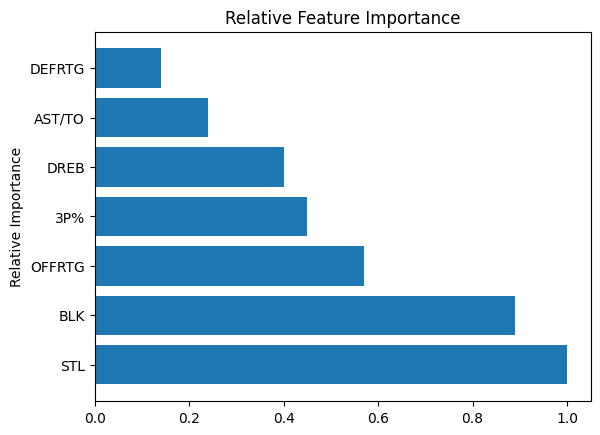

In [36]:
# Relative feature importance plot.
fig, ax = plt.subplots()
ax.barh(feature_importance.index, feature_importance["Relative Importance"])
ax.set_title("Relative Feature Importance")
ax.set_ylabel("Relative Importance")

# Save image to file.
fig.savefig(
    fname=images_dir / "feature_importance.png",
    dpi=image_dpi,
    bbox_inches="tight",
)

plt.show()